# MAT017 - Cálculo
## Trabalho - parte 3
Resolvendo problema de distribuição de probabilidade utilizando o **Método de Monte Carlo**.

Autores:
- Fernando Gomes
- Helena Barboza

## Problema
Temos uma carteira de investimentos composta por dois ativos, A e B. As distribuições de retorno anual para esses ativos são conhecidas e são as seguintes:
- O retorno do ativo A segue uma distribuição normal com média de 7% e desvio padrão de 10%.
- O retorno do ativo B segue uma distribuição normal com média de 5% e desvio padrão de 8%.

Investimos 50% do capital em cada ativo. Iremos calcular a probabilidade de a carteira ter um retorno anual negativo (ou seja, perder dinheiro) usando o **Método de Monte Carlo**.

In [1]:
!pip install pymc numpy arviz ipywidgets matplotlib

In [2]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Parâmetros das distribuições
mean_A = 0.07
std_dev_A = 0.10
mean_B = 0.05
std_dev_B = 0.08

# Número de simulações
N = 50000

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## distribuições dos retornos

Ativo A: $R_A \sim N(0.07, 0.10)$

Ativo B: $R_B \sim N(0.05, 0.8)$

In [3]:
# Definindo o modelo
with pm.Model() as model:
    # Distribuições dos retornos dos ativos
    R_A = pm.Normal("R_A", mu=mean_A, sigma=std_dev_A)
    R_B = pm.Normal("R_B", mu=mean_B, sigma=std_dev_B)
    
    # Retorno da carteira
    R_C = 0.5 * R_A + 0.5 * R_B
    
    # Amostragem usando Monte Carlo via MCMC
    # Aqui estamos aplicando o método de Monte Carlo para gerar amostras
    trace = pm.sample(N, return_inferencedata=True)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:50

Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 51 seconds.


In [4]:
# Análise dos resultados
# Extraímos as amostras geradas para calcular os retornos da carteira
returns_C = trace.posterior["R_A"].values.flatten() * 0.5 + trace.posterior["R_B"].values.flatten() * 0.5

# Cálculo da probabilidade de retorno negativo
# Contamos a proporção de amostras em que o retorno da carteira é negativo
prob_negative_return = np.mean(returns_C < 0)

In [5]:
# Resumo estatístico
summary = az.summary(trace, var_names=["R_A", "R_B"])
summary_returns_C = {
    'mean': np.mean(returns_C),
    'std': np.std(returns_C),
    '25%': np.percentile(returns_C, 25),
    '50%': np.percentile(returns_C, 50),
    '75%': np.percentile(returns_C, 75)
}

In [6]:
# Exibir os resultados
print("-" * 20+ " Resultados " + "-" * 20, "\n")
print("Probabilidade de retorno negativo da carteira: {:.2f}%".format(prob_negative_return * 100))

# Condição 1: Probabilidade de retorno positivo da carteira
prob_positive_return = np.mean(returns_C > 0)
print("Probabilidade de retorno positivo da carteira: {:.2f}%".format(prob_positive_return * 100))

# Condição 2: Probabilidade de R_A ser maior que R_B
prob_A_higher_than_B = np.mean(trace.posterior["R_A"].values.flatten() > trace.posterior["R_B"].values.flatten())
print("Probabilidade de R_A ser maior que R_B: {:.2f}%".format(prob_A_higher_than_B * 100))

print("\nResumo estatístico dos retornos dos ativos:")
print(summary)
print("\nResumo estatístico dos retornos da carteira:")
for key, value in summary_returns_C.items():
    print(f"{key}: {value:.4f}")

-------------------- Resultados -------------------- 

Probabilidade de retorno negativo da carteira: 17.59%
Probabilidade de retorno positivo da carteira: 82.41%
Probabilidade de R_A ser maior que R_B: 56.36%

Resumo estatístico dos retornos dos ativos:
      mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R_A  0.070  0.10  -0.117    0.258        0.0      0.0  210573.0  151165.0   
R_B  0.049  0.08  -0.102    0.199        0.0      0.0  209146.0  150935.0   

     r_hat  
R_A    1.0  
R_B    1.0  

Resumo estatístico dos retornos da carteira:
mean: 0.0597
std: 0.0638
25%: 0.0166
50%: 0.0598
75%: 0.1027


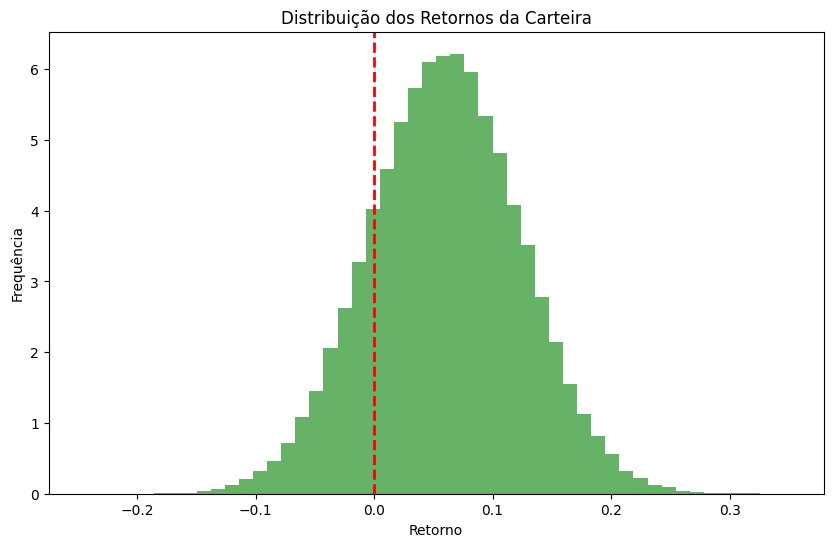

In [7]:
# Plotando a distribuição dos retornos da carteira
plt.figure(figsize=(10, 6))
plt.hist(returns_C, bins=50, density=True, alpha=0.6, color='g')
plt.title("Distribuição dos Retornos da Carteira")
plt.xlabel("Retorno")
plt.ylabel("Frequência")
plt.axvline(0, color='r', linestyle='dashed', linewidth=2)
plt.show()